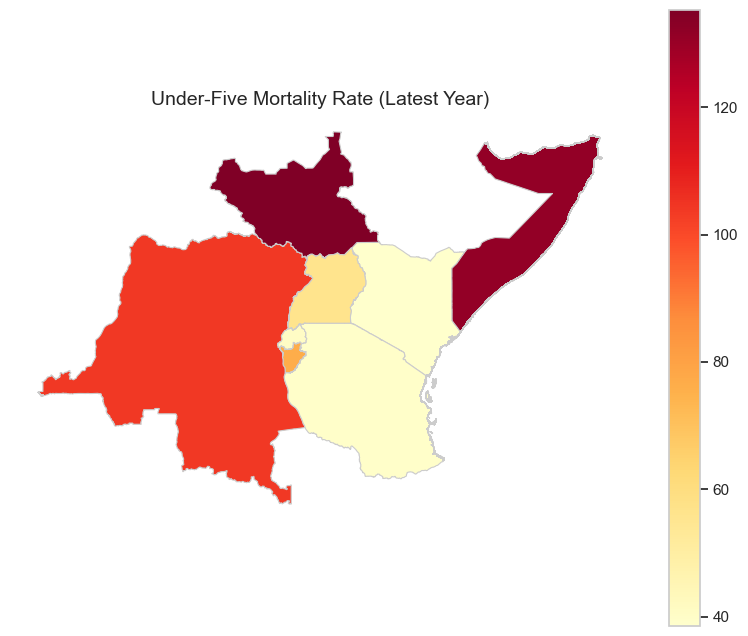

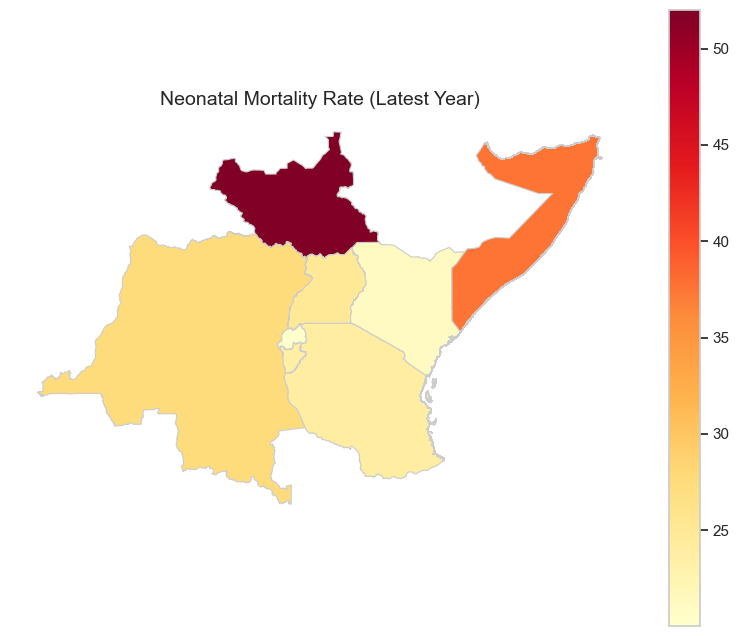

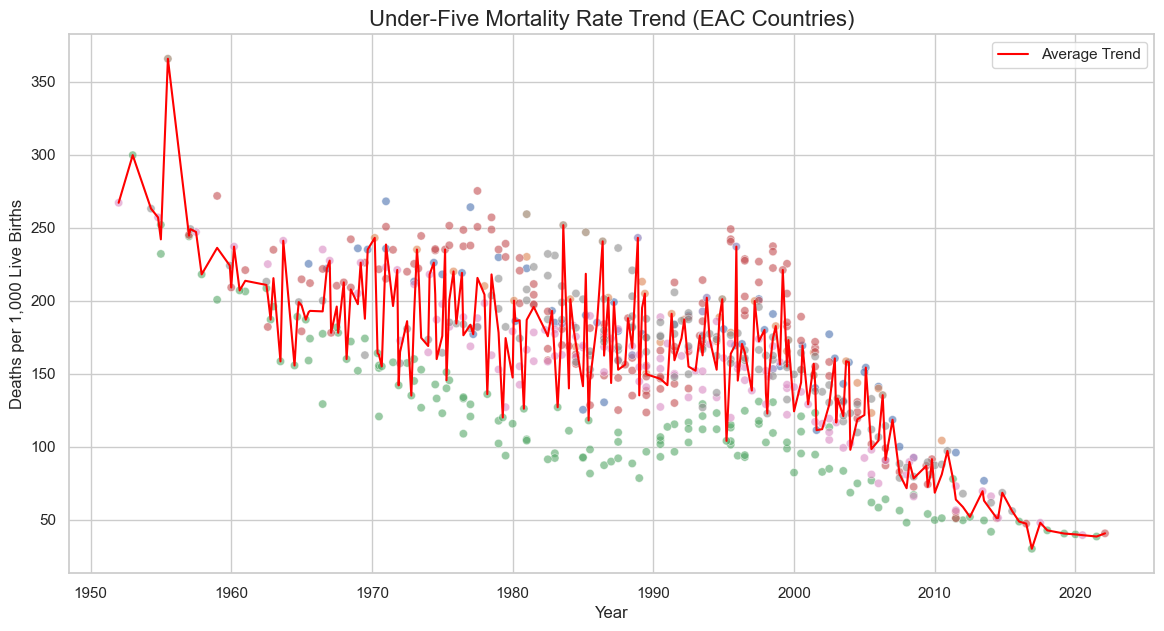

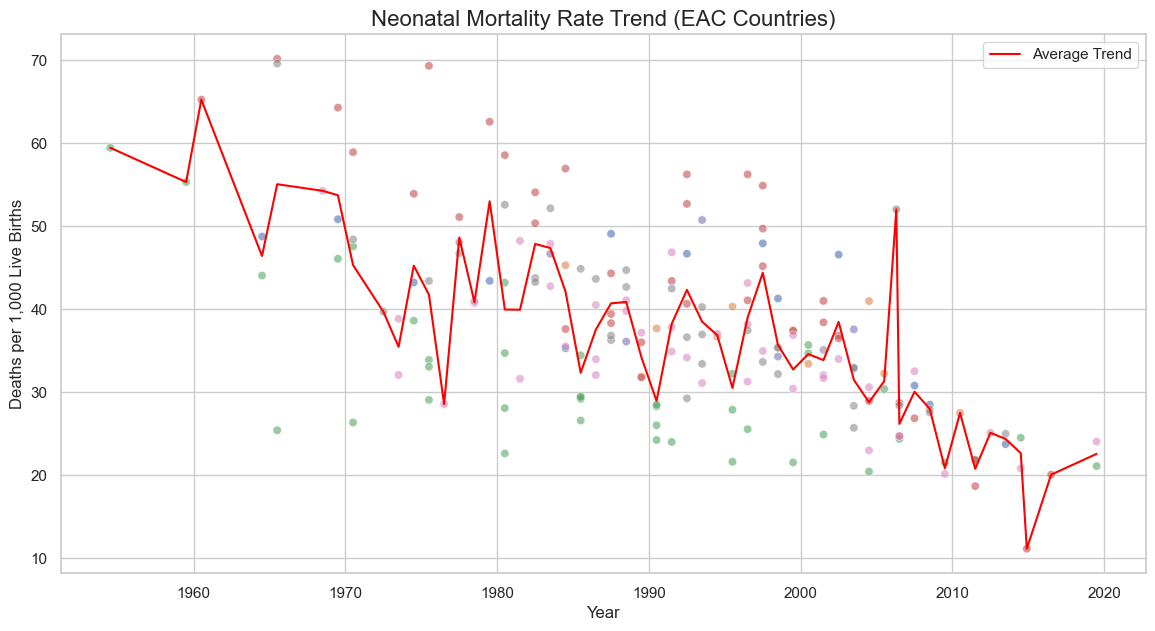

Highest Under-Five Mortality Rate: South Sudan (SSD) with 135.3 deaths/1000 live births (Year 2006)
Highest Neonatal Mortality Rate: South Sudan (SSD) with 52.0 deaths/1000 live births (Year 2006)


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up 
sns.set_theme(style="whitegrid")

DATA_FILE = 'neonatal_datascience.csv'  # Update path if needed
SHAPEFILE_PATH = 'Africa_Boundaries.shp'  # Update path if needed

EAC_ISO_CODES = ['KEN', 'UGA', 'TZA', 'SOM', 'SSD', 'RWA', 'BDI', 'COD']

# --- Load Data ---

df = pd.read_csv(DATA_FILE, low_memory=False)

# Basic validation
required_cols = ['REF_AREA', 'Indicator', 'Sex', 'Wealth Quintile', 'Reference Date', 'Observation Value', 'Observation Status']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"Missing columns in dataset: {set(required_cols) - set(df.columns)}")

# Filtering for EAC, Total Sex & Wealth, and valid observations
df = df[
    (df['REF_AREA'].isin(EAC_ISO_CODES)) &
    (df['Sex'] == 'Total') &
    (df['Wealth Quintile'] == 'Total') &
    (df['Observation Status'] == 'Included in IGME')
]

# Ensuring numeric Year & Mortality Rate as we have .5 years
df['Year'] = pd.to_numeric(df['Reference Date'], errors='coerce')
df['Observation Value'] = pd.to_numeric(df['Observation Value'], errors='coerce')

# Splitting by indicator
df_u5 = df[df['Indicator'] == 'Under-five mortality rate']
df_neo = df[df['Indicator'] == 'Neonatal mortality rate']

# Getting Latest Estimates
def latest_by_country(df_indicator):
    return df_indicator.sort_values('Year', ascending=False).drop_duplicates('REF_AREA')

latest_u5 = latest_by_country(df_u5)
latest_neo = latest_by_country(df_neo)

# Loading Shapefile
world = gpd.read_file(SHAPEFILE_PATH)

# Detecting ISO code column
iso_col = next((col for col in ['GID_0', 'ADM0_A3', 'ISO'] if col in world.columns), None)
if not iso_col:
    raise ValueError("No suitable ISO column found in shapefile.")

# Subset for EAC countries
world_eac = world[world[iso_col].isin(EAC_ISO_CODES)].copy()
world_eac = world_eac.rename(columns={iso_col: 'REF_AREA'})

# Mapping Function
def plot_mortality_map(gdf, latest_df, title, cmap="YlOrRd"):
    merged = gdf.merge(latest_df[['REF_AREA', 'Observation Value']], on='REF_AREA', how='left')
    fig, ax = plt.subplots(figsize=(10,8))
    merged.plot(column='Observation Value', cmap=cmap, linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.show()

# Plotting Maps 
plot_mortality_map(world_eac, latest_u5, "Under-Five Mortality Rate (Latest Year)")
plot_mortality_map(world_eac, latest_neo, "Neonatal Mortality Rate (Latest Year)")

# Checking Trends Over Time
def plot_trends(df_indicator, indicator_name):
    avg_trend = df_indicator.groupby('Year')['Observation Value'].mean()
    plt.figure(figsize=(14,7))
    sns.lineplot(x=avg_trend.index, y=avg_trend.values, label='Average Trend', color='red')
    sns.scatterplot(data=df_indicator, x='Year', y='Observation Value', hue='REF_AREA', alpha=0.6, legend=False)
    plt.title(f"{indicator_name} Trend (EAC Countries)", fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Deaths per 1,000 Live Births")
    plt.grid(True)
    plt.show()

plot_trends(df_u5, "Under-Five Mortality Rate")
plot_trends(df_neo, "Neonatal Mortality Rate")

# Identifying Highest Mortality Country
def highest_mortality(latest_df, indicator_name):
    row = latest_df.loc[latest_df['Observation Value'].idxmax()]
    print(f"Highest {indicator_name}: {row['Geographic area']} ({row['REF_AREA']}) with {row['Observation Value']:.1f} deaths/1000 live births (Year {row['Year']:.0f})")

highest_mortality(latest_u5, "Under-Five Mortality Rate")
highest_mortality(latest_neo, "Neonatal Mortality Rate")
